# L'Algorithme de Shor

L’algorithme de Shor est célèbre pour la factorisation des entiers en temps polynomial. Étant donné que l'algorithme classique le plus connu nécessite un temps superpolynomial pour factoriser le produit de deux nombres premiers, le cryptosystème largement utilisé, RSA, repose sur l'impossibilité de factoriser pour des entiers suffisamment grands.

Dans ce cours, nous nous concentrerons sur la partie quantique de l’algorithme de Shor, qui résout en fait le problème de la recherche de périodes. Puisqu'un problème de factorisation peut être transformé en un problème de recherche de période en temps polynomial, un algorithme de recherche de période efficace peut également être utilisé pour factoriser efficacement les entiers. Pour l'instant, il suffit de montrer que si nous pouvons calculer la période de 𝑎𝑥mod𝑁
efficacement, alors nous pouvons également factoriser efficacement. Étant donné que la recherche de périodes est un problème valable en soi, nous allons d'abord le résoudre, puis discuter de la façon dont cela peut être utilisé pour prendre en compte dans la section 5.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
print("Imports Successful")

Imports Successful


## 1. Le problème : Trouver la période

Regardons la fonction périodique:


$$ f(x) = a^x \bmod{N}$$

<details>
    <summary>Rappel: Modulo & amp; Arithmétique modulaire 

L'opération modulo (abrégée en «mod») signifie simplement trouver le reste lors de la division d'un nombre par un autre. Par example:

$$ 17 \bmod 5 = 2 $$
        </summary>

Since $17 \div 5 = 3$ with remainder $2$. (i.e. $17 = (3\times 5) + 2$). In Python, the modulo operation is denoted through the <code>%</code> symbol.

This behaviour is used in <a href="https://en.wikipedia.org/wiki/Modular_arithmetic">modular arithmetic</a>, where numbers 'wrap round' after reaching a certain value (the modulus). Using modular arithmetic, we could write:

$$ 17 = 2 \pmod 5$$

Note that here the $\pmod 5$ applies to the entire equation (since it is in parenthesis), unlike the equation above where it only applied to the left-hand side of the equation.
</details>

où $a$ et $N$ sont des entiers positifs, $a$ est inférieur à $N$ et ils n'ont pas de facteurs communs. La période, ou ordre ($r$), est le plus petit entier (non nul) tel que:

$$a^r \bmod N = 1 $$ 

Nous pouvons voir un exemple de cette fonction tracée sur le graphique ci-dessous. Notez que les lignes entre les points aident à voir la périodicité et ne représentent pas les valeurs intermédiaires entre les marqueurs x.

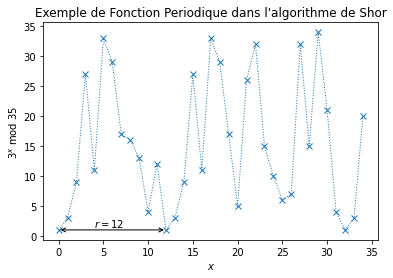

In [24]:
N = 35
a = 3

# Calculer les données
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# Affichage avec MatPlotLib
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel='$%i^x$ mod $%i$' % (a, N),
       title="Exemple de Fonction Periodique dans l'algorithme de Shor")
try: # Affichage de r
    r = yvals[1:].index(1) +1 
    plt.annotate('', xy=(0,1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
    plt.annotate('$r=%i$' % r, xy=(r/3,1.5))
except ValueError:
    print('Ne peut pas trouver la période, vérifier que a < N et pas de facteurs communs.')

## 2. La Solution (théorie)

La solution de Shor a consisté à utiliser l'estimation de phase quantique (quantum-phase-estimation.html) sur l'opérateur unitaire:

$$ U|y\rangle \equiv |ay \bmod N \rangle $$

Pour voir en quoi cela est utile, voyons à quoi pourrait ressembler un état propre de U. Si nous avons commencé dans l'état $|1\rangle$, nous pouvons voir que chaque application successive de U multipliera l'état de notre registre par $a \pmod N$, et après $r$ applications nous arriverons à l'état $|1\rangle$ à nouveau. Par exemple avec $a = 3$ et $N = 35$:

$$\begin{aligned}
U|1\rangle &= |3\rangle & \\
U^2|1\rangle &= |9\rangle \\
U^3|1\rangle &= |27\rangle \\
& \vdots \\
U^{(r-1)}|1\rangle &= |12\rangle \\
U^r|1\rangle &= |1\rangle 
\end{aligned}$$

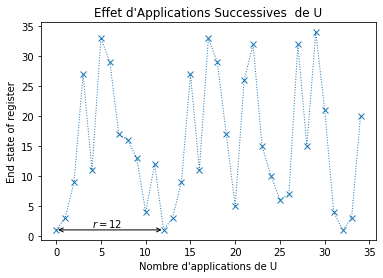

In [26]:
ax.set(xlabel="Nombre d'applications de U", ylabel='End state of register',
       title="Effet d'Applications Successives  de U")
fig

Donc une superposition des états dans ce cycle (|𝑢0⟩) serait un état propre de 𝑈:

$$|u_0\rangle = \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{|a^k \bmod N\rangle} $$


<details>
    <summary> </summary>

$$\begin{aligned}
|u_0\rangle &= \tfrac{1}{\sqrt{12}}(|1\rangle + |3\rangle + |9\rangle \dots + |4\rangle + |12\rangle) \\[10pt]
U|u_0\rangle &= \tfrac{1}{\sqrt{12}}(U|1\rangle + U|3\rangle + U|9\rangle \dots + U|4\rangle + U|12\rangle) \\[10pt]
 &= \tfrac{1}{\sqrt{12}}(|3\rangle + |9\rangle + |27\rangle \dots + |12\rangle + |1\rangle) \\[10pt]
 &= |u_0\rangle
\end{aligned}$$
</details>


Cet état propre a une valeur propre de 1, ce qui n’est pas très intéressant. Un état propre plus intéressant pourrait être celui dans lequel la phase est différente pour chacun de ces états de base de calcul. Plus précisément, examinons le cas où la phase de l'état $k$th est proportionnelle à $k$:

$$\begin{aligned}
|u_1\rangle &= \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{e^{-\tfrac{2\pi i k}{r}}|a^k \bmod N\rangle}\\[10pt]
U|u_1\rangle &= e^{\tfrac{2\pi i}{r}}|u_1\rangle 
\end{aligned}
$$

<details>
    <summary></summary>

$$\begin{aligned}
|u_1\rangle &= \tfrac{1}{\sqrt{12}}(|1\rangle + e^{-\tfrac{2\pi i}{12}}|3\rangle + e^{-\tfrac{4\pi i}{12}}|9\rangle \dots + e^{-\tfrac{20\pi i}{12}}|4\rangle + e^{-\tfrac{22\pi i}{12}}|12\rangle) \\[10pt]
U|u_1\rangle &= \tfrac{1}{\sqrt{12}}(|3\rangle + e^{-\tfrac{2\pi i}{12}}|9\rangle + e^{-\tfrac{4\pi i}{12}}|27\rangle \dots + e^{-\tfrac{20\pi i}{12}}|12\rangle + e^{-\tfrac{22\pi i}{12}}|1\rangle) \\[10pt]
U|u_1\rangle &= e^{\tfrac{2\pi i}{12}}\cdot\tfrac{1}{\sqrt{12}}(e^{\tfrac{-2\pi i}{12}}|3\rangle + e^{-\tfrac{4\pi i}{12}}|9\rangle + e^{-\tfrac{6\pi i}{12}}|27\rangle \dots + e^{-\tfrac{22\pi i}{12}}|12\rangle + e^{-\tfrac{24\pi i}{12}}|1\rangle) \\[10pt]
U|u_1\rangle &= e^{\tfrac{2\pi i}{12}}|u_1\rangle
\end{aligned}$$

(We can see $r = 12$ appears in the denominator of the phase.)
</details>

C'est une valeur propre particulièrement intéressante car elle contient $r$. En fait, $r$ doit être inclus pour s'assurer que les différences de phase entre les états de base de calcul $r$ sont égales. Ce n'est pas le seul état propre avec ce comportement; pour généraliser cela davantage, nous pouvons multiplier un entier, $s$, à cette différence de phase, qui apparaîtra dans notre valeur propre:

$$\begin{aligned}
|u_s\rangle &= \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{e^{-\tfrac{2\pi i s k}{r}}|a^k \bmod N\rangle}\\[10pt]
U|u_s\rangle &= e^{\tfrac{2\pi i s}{r}}|u_s\rangle 
\end{aligned}
$$

<details>
    <summary></summary>

$$\begin{aligned}
|u_s\rangle &= \tfrac{1}{\sqrt{12}}(|1\rangle + e^{-\tfrac{2\pi i s}{12}}|3\rangle + e^{-\tfrac{4\pi i s}{12}}|9\rangle \dots + e^{-\tfrac{20\pi i s}{12}}|4\rangle + e^{-\tfrac{22\pi i s}{12}}|12\rangle) \\[10pt]
U|u_s\rangle &= \tfrac{1}{\sqrt{12}}(|3\rangle + e^{-\tfrac{2\pi i s}{12}}|9\rangle + e^{-\tfrac{4\pi i s}{12}}|27\rangle \dots + e^{-\tfrac{20\pi i s}{12}}|12\rangle + e^{-\tfrac{22\pi i s}{12}}|1\rangle) \\[10pt]
U|u_s\rangle &= e^{\tfrac{2\pi i s}{12}}\cdot\tfrac{1}{\sqrt{12}}(e^{-\tfrac{2\pi i s}{12}}|3\rangle + e^{-\tfrac{4\pi i s}{12}}|9\rangle + e^{-\tfrac{6\pi i s}{12}}|27\rangle \dots + e^{-\tfrac{22\pi i s}{12}}|12\rangle + e^{-\tfrac{24\pi i s}{12}}|1\rangle) \\[10pt]
U|u_s\rangle &= e^{\tfrac{2\pi i s}{12}}|u_s\rangle
\end{aligned}$$

</details>

Nous avons maintenant un état propre unique pour chaque valeur entière de $s$ où $$0 \ leqs \ leq r-1 $$. Très commodément, si nous résumons tous ces états propres, les différentes phases annulent tous les états de base de calcul sauf $|1\rangle$:

$$ \tfrac{1}{\sqrt{r}}\sum_{s=0}^{r-1} |u_s\rangle = |1\rangle$$

<details>
    <summary></summary>

For this, we will look at a smaller example where $a = 7$ and $N=15$. In this case $r=4$:

$$\begin{aligned}
\tfrac{1}{2}(\quad|u_0\rangle &= \tfrac{1}{2}(|1\rangle \hphantom{e^{-\tfrac{2\pi i}{12}}}+ |7\rangle \hphantom{e^{-\tfrac{12\pi i}{12}}} + |4\rangle \hphantom{e^{-\tfrac{12\pi i}{12}}} + |13\rangle)\dots \\[10pt]
+ |u_1\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{2\pi i}{4}}|7\rangle + e^{-\tfrac{\hphantom{1}4\pi i}{4}}|4\rangle + e^{-\tfrac{\hphantom{1}6\pi i}{4}}|13\rangle)\dots \\[10pt]
+ |u_2\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{4\pi i}{4}}|7\rangle + e^{-\tfrac{\hphantom{1}8\pi i}{4}}|4\rangle + e^{-\tfrac{12\pi i}{4}}|13\rangle)\dots \\[10pt]
+ |u_3\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{6\pi i}{4}}|7\rangle + e^{-\tfrac{12\pi i}{4}}|4\rangle + e^{-\tfrac{18\pi i}{4}}|13\rangle)\quad) = |1\rangle \\[10pt]
\end{aligned}$$

</details>

Puisque l'état de base de calcul $|1\rangle$ est une superposition de ces états propres, ce qui signifie que si nous faisons QPE (Quantum Phase Estimation) sur $U$ en utilisant l'état $|1\rangle$, nous mesurerons une phase:

$$\phi = \frac{s}{r}$$

Où $s$ est un entier aléatoire entre $0$ et $r-1$. Nous utilisons enfin l'algorithme [fractions continues] (https://en.wikipedia.org/wiki/Continued_fraction) sur $\phi$ pour trouver $r$. 



Nous allons ensuite démontrer l’algorithme de Shor à l’aide des simulateurs de Qiskit. Pour cette démonstration, nous fournirons les circuits pour $U$ sans explication, mais dans la section 4, nous discuterons de la manière dont les circuits pour $U^{2^j}$ peuvent être construits efficacement.

## 3.  Implementation Qiskit

Dans cet exemple, nous allons résoudre le problème de recherche de période pour $a = 7$ et $N = 15$. Nous fournissons les circuits pour $U$ où:

$$U|y\rangle = |ay\bmod 15\rangle $$

Pour créer $U^x$, nous allons simplement répéter le circuit $x$ fois. Dans la section suivante, nous discuterons d'une méthode générale pour créer efficacement ces circuits. La fonction `c_amod15` renvoie la porte U contrôlée répétées` a`, fois `power` .

In [4]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

Nous utiliserons 8 qubits de comptage:

In [5]:
# Specify variables
n_count = 8  # number of counting qubits
a = 7

Nous importons également le circuit pour le QFT (vous pouvez en savoir plus sur le QFT dans le [chapitre transformée de Fourier quantique ] (quantum-fourier-transform.html):

In [6]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

Avec ces blocs de construction, nous pouvons facilement construire le circuit de l'algorithme de Shor:

In [7]:
# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(n_count + 4, n_count)

# Initialise counting qubits
# in state |+>
for q in range(n_count):
    qc.h(q)
    
# And auxiliary register in state |1>
qc.x(3+n_count)

# Do controlled-U operations
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))
qc.draw(fold=-1)  # -1 means 'do not fold' 

┌───┐                                                                                                                             ┌───────┐┌─┐                     
 q_0: ┤ H ├───────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0      ├┤M├─────────────────────
      ├───┤       │                                                                                                                     │       │└╥┘┌─┐                  
 q_1: ┤ H ├───────┼──────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────┤1      ├─╫─┤M├──────────────────
      ├───┤       │              │                                                                                                      │       │ ║ └╥┘┌─┐               
 q_2: ┤ H ├───────┼──────────────┼──────────────■───────────────────────────────────────────────────────────────────────────────────────┤2      ├─╫──╫─┤M├───────────────
      ├───┤       │              │              │                                                                                       │       │ ║  ║ └╥┘┌─┐            
 q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■────────────────────────────────────────────────────────────────────────┤3      ├─╫──╫──╫─┤M├────────────
      ├───┤       │              │              │              │                                                                        │  QFT† │ ║  ║  ║ └╥┘┌─┐         
 q_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────■─────────────────────────────────────────────────────────┤4      ├─╫──╫──╫──╫─┤M├─────────
      ├───┤       │              │              │              │              │                                                         │       │ ║  ║  ║  ║ └╥┘┌─┐      
 q_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────■─────────────────────────────────────────┤5      ├─╫──╫──╫──╫──╫─┤M├──────
      ├───┤       │              │              │              │              │               │                                         │       │ ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────■─────────────────────────┤6      ├─╫──╫──╫──╫──╫──╫─┤M├───
      ├───┤       │              │              │              │              │               │               │                         │       │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
 q_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────┼────────────────■────────┤7      ├─╫──╫──╫──╫──╫──╫──╫─┤M├
      └───┘┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌───────┴───────┐└───────┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
 q_8: ─────┤0            ├┤0            ├┤0            ├┤0            ├┤0             ├┤0             ├┤0             ├┤0              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
 q_9: ─────┤1            ├┤1            ├┤1            ├┤1            ├┤1             ├┤1             ├┤1             ├┤1              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 ││  7^8 mod 15 ││  7^16 mod 15 ││  7^32 mod 15 ││  7^64 mod 15 ││  7^128 mod 15 │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_10: ─────┤2            ├┤2            ├┤2            ├┤2            ├┤2             ├┤2             ├┤2             ├┤2              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
      ┌───┐│             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_11: ┤ X ├┤3            ├┤3            ├┤3            ├┤3            ├┤3             ├┤3       

Voyons quels résultats nous mesurons:

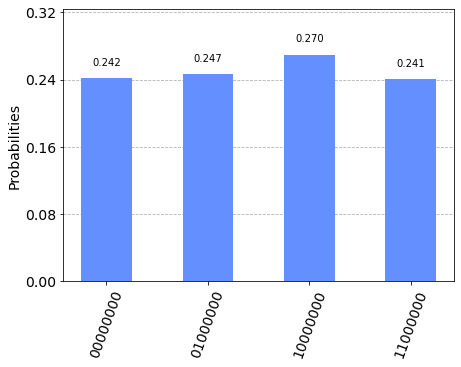

In [8]:
qasm_sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(qc, qasm_sim)
qobj = assemble(t_qc)
results = qasm_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

Puisque nous avons 3 qubits, ces résultats correspondent à des phases mesurées de:

In [9]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  00000000(bin) =   0(dec)    0/256 = 0.00
1  01000000(bin) =  64(dec)   64/256 = 0.25
2  10000000(bin) = 128(dec)  128/256 = 0.50
3  11000000(bin) = 192(dec)  192/256 = 0.75


Nous pouvons maintenant utiliser l'algorithme des fractions continues pour tenter de trouver $s$ et $r$. Python a cette fonctionnalité intégrée: Nous pouvons utiliser le module `fractions` pour transformer un réel en objet` Fraction`, par exemple:

In [10]:
Fraction(0.666)

Fraction(5998794703657501, 9007199254740992)

Parce que cela donne des fractions qui renvoient exactement le résultat (dans ce cas, `0,6660000 ...`), cela peut donner des résultats épouvantables comme celui ci-dessus. Nous pouvons utiliser la méthode `.limit_denominator ()` pour obtenir la fraction qui ressemble le plus à notre flottant, avec un dénominateur inférieur à une certaine valeur:

In [11]:
# Get fraction that most closely resembles 0.666
# with denominator < 15
Fraction(0.666).limit_denominator(15)

Fraction(2, 3)

Bien mieux! L'ordre (r) doit être inférieur à N, nous allons donc définir le dénominateur maximum à «15»:

In [12]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.00      0/1            1
1   0.25      1/4            4
2   0.50      1/2            2
3   0.75      3/4            4


Nous pouvons voir que deux des valeurs propres mesurées nous ont fourni le résultat correct: $r = 4$, et nous pouvons voir que l’algorithme de Shor a une chance d’échouer. Ces mauvais résultats sont dus au fait que $s = 0$, ou parce que $s$ et $r$ ne sont pas premiers et au lieu de $r$ on nous donne un facteur de $r$. La solution la plus simple à cela est de simplement répéter l'expérience jusqu'à ce que nous obtenions un résultat satisfaisant pour $r$.

### Exercice :

- Modifiez le circuit ci-dessus pour les valeurs de $a = 2, 8, 11 et 13. Quels résultats obtenez-vous et pourquoi?

## 4.Exponentiation modulaire

Vous avez peut-être remarqué que la méthode de création des portes $U^{2^j}$ en répétant $U$ croît exponentiellement avec $j$ et n'aboutira pas à un algorithme de temps polynomial. Nous voulons un moyen de créer l'opérateur:

$$ U^{2^j}|y\rangle = |a^{2^j}y \bmod N \rangle $$

qui croît polynomialement avec $j$. Heureusement, calculer:

$$ a^{2^j} \bmod N$$

efficacement est possible. Les ordinateurs classiques peuvent utiliser un algorithme appelé «quadrillage répété» pour calculer une exponentielle. Dans notre cas, puisque nous ne traitons que des exponentielles de la forme $2^j$, l'algorithme de quadrillage répété devient très simple:

In [13]:
def a2jmodN(a, j, N):
    """Compute a^{2^j} (mod N) by repeated squaring"""
    for i in range(j):
        a = np.mod(a**2, N)
    return a

In [14]:
a2jmodN(7, 2049, 53)

47

Si un algorithme efficace est possible en Python, alors nous pouvons utiliser le même algorithme sur un ordinateur quantique. Malheureusement, malgré la mise à l’échelle polynomiale avec $j$, les circuits d’exponentiation modulaires ne sont pas simples et constituent le goulot d’étranglement de l’algorithme de Shor. 

## 5. Factorisation à partir de la recherche de période

Tous les problèmes de factorisation ne sont pas difficiles; nous pouvons repérer instantanément un nombre pair et savoir que l'un de ses facteurs est 2. En fait, il existe des critères spécifiques (https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.186-4.pdf ) pour choisir des nombres qui sont difficiles à factoriser, mais l'idée de base est de choisir le produit de deux grands nombres premiers.

Un algorithme de factorisation général vérifiera d'abord s'il existe un raccourci pour factoriser l'entier (le nombre est-il pair? Le nombre est-il de la forme $N = a^b$?), Avant d'utiliser la recherche de période de Shor pour le pire des cas . Puisque nous cherchons à nous concentrer sur la partie quantique de l'algorithme, nous allons passer directement au cas où N est le produit de deux nombres premiers.

### Exemple: Factoriser 15

Pour voir un exemple de factorisation sur un petit nombre de qubits, nous allons factoriser 15, qui, nous le savons tous, est le produit des nombres premiers pas si grands 3 et 5.

In [15]:
N = 15

La première étape consiste à choisir un nombre aléatoire, $x$, entre $1$ et $N-1$:

In [16]:
np.random.seed(1) # This is to make sure we get reproduceable results
a = randint(2, 15)
print(a)

7


Ensuite, nous vérifions rapidement que ce n'est pas déjà un facteur non trivial de $N$:

In [17]:
from math import gcd # greatest common divisor
gcd(a, N)

1

Génial. Ensuite, nous faisons l'algorithme de recherche d'ordres de Shor pour `a = 7` et` N = 15`. N'oubliez pas que la phase que nous mesurons sera $s/r$ où:

$$ a^r \bmod N = 1 $$

et $s$ est un entier aléatoire entre 0 et $r-1$.

In [18]:
def qpe_amod15(a):
    n_count = 8
    qc = QuantumCircuit(4+n_count, n_count)
    for q in range(n_count):
        qc.h(q)     # Initialise counting qubits in state |+>
    qc.x(3+n_count) # And auxiliary register in state |1>
    for q in range(n_count): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q), 
                 [q] + [i+n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count)) # Do inverse-QFT
    qc.measure(range(n_count), range(n_count))
    # Simulate Results
    qasm_sim = Aer.get_backend('qasm_simulator')
    # Setting memory=True below allows us to see a list of each sequential reading
    t_qc = transpile(qc, qasm_sim)
    obj = assemble(t_qc, shots=1)
    result = qasm_sim.run(qobj, memory=True).result()
    readings = result.get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    return phase

À partir de cette phase, nous pouvons facilement trouver une estimation pour $r$:

In [19]:
phase = qpe_amod15(a) # Phase = s/r
Fraction(phase).limit_denominator(15) # Denominator should (hopefully!) tell us r

Register Reading: 00000000
Corresponding Phase: 0.000000


Fraction(0, 1)

In [20]:
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)

1


Maintenant que nous avons $r$, nous pourrons peut-être l'utiliser pour trouver un facteur de $N$:

$$a^r \bmod N = 1 $$

puis

$$(a^r - 1) \bmod N = 0 $$

ce qui signifie que $N$ doit diviser $a^r-1$. Et si $r$ est également pair, alors nous pouvons écrire:

$$a^r -1 = (a^{r/2}-1)(a^{r/2}+1)$$

(si $r$ n'est pas pair, nous ne pouvons pas aller plus loin et devons réessayer avec une valeur différente pour $a$). Il y a alors une forte probabilité que le plus grand diviseur commun de $N$ et soit $a^{r/2}-1$, soit $a^{r/2}+1$ soit un facteur propre de $N$ :

In [21]:
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

[15, 1]


La cellule ci-dessous répète l'algorithme jusqu'à ce qu'au moins un facteur de 15 soit trouvé. Vous devriez essayer de réexécuter la cellule plusieurs fois pour voir comment elle se comporte.

In [22]:
a = 7
factor_found = False
attempt = 0
while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
    r = frac.denominator
    print("Result: r = %i" % r)
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True


Attempt 1:
Register Reading: 10000000
Corresponding Phase: 0.500000
Result: r = 2
Guessed Factors: 3 and 1
*** Non-trivial factor found: 3 ***


## 6. References

1. Stephane Beauregard, _Circuit for Shor's algorithm using 2n+3 qubits,_ [arXiv:quant-ph/0205095](https://arxiv.org/abs/quant-ph/0205095)

2. M. Nielsen and I. Chuang, _Quantum Computation and Quantum Information,_ Cambridge Series on Information and the Natural Sciences (Cambridge University Press, Cambridge, 2000). (Page 633)

In [27]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.1',
 'qiskit-aer': '0.7.2',
 'qiskit-ignis': '0.5.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.1',
 'qiskit': '0.23.2'}